In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.signal import butter, filtfilt, welch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import svm
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### Load Dataset

In [2]:
eeg_predictive_train = np.load('../data/eeg-predictive_train.npz')
eeg_predictive_val_balanced = np.load('../data/eeg-predictive_val_balanced.npz')
eeg_predictive_val = np.load('../data/eeg-predictive_val.npz')
signals, labels = eeg_predictive_train['train_signals'], eeg_predictive_train['train_labels']
signals_val, labels_val = eeg_predictive_val_balanced['val_signals'], eeg_predictive_val_balanced['val_labels']
signals_val_unbalanced, labels_val_unbalanced = eeg_predictive_val['val_signals'], eeg_predictive_val['val_labels']


In [3]:
eeg_seizure_train = np.load('../data/eeg-seizure_train.npz')
eeg_seizure_val_balanced = np.load('../data/eeg-seizure_val_balanced.npz')

signals_seizure, labels_seizure = eeg_seizure_train['train_signals'], eeg_seizure_train['train_labels']
signals_seizure_test, labels_seizure_test = eeg_seizure_val_balanced['val_signals'], eeg_seizure_val_balanced['val_labels']

### Preprocess and Reduce Dimensionality

In [4]:
def preprocess(signals):
    # Parameters
    fs = 256  # Sampling frequency in Hz
    bandpass_lowcut = 0.5  # Lower cutoff frequency in Hz
    bandpass_highcut = 60.0  # Upper cutoff frequency in Hz

    # Create the Butterworth bandpass filter
    def butter_bandpass(bandpass_lowcut, bandpass_highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = bandpass_lowcut / nyquist
        high = bandpass_highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    # Apply zero-phase Butterworth bandpass filter using filtfilt
    def bandpass_filter(data, bandpass_lowcut, bandpass_highcut, fs, order=4):
        b, a = butter_bandpass(bandpass_lowcut, bandpass_highcut, fs, order=order)
        # Apply along the last axis (time axis)
        filtered_data = filtfilt(b, a, data, axis=-1)
        return filtered_data

    # # Example 3D EEG data (samples x channels x time)
    eeg_data = signals

    # Apply the filter to the EEG data
    filtered_eeg = bandpass_filter(eeg_data, bandpass_lowcut, bandpass_highcut, fs)

    # Example 3D EEG data (samples x channels x time)
    eeg_data = filtered_eeg

    # Compute the common average reference
    mean_across_channels = np.mean(eeg_data, axis=1, keepdims=True)  # Shape: (samples, 1, time)

    # Subtract the mean from each channel
    car_filtered_data = eeg_data - mean_across_channels
    
    # Parameters
    lowcut = 2  # Lower cutoff frequency in Hz
    highcut = 40  # Upper cutoff frequency in Hz
    epoch_duration = 1. # Duration of each epoch in seconds
    nperseg = int(epoch_duration * fs)  # Number of samples per segment (128 for 0.5 seconds at 256 Hz)

    # Example 3D EEG data (samples x channels x time)
    samples, channels, _ = car_filtered_data.shape
    eeg_data = car_filtered_data

    # Define a function to calculate spectral power in the desired frequency range
    def compute_spectral_power(data, fs, lowcut, highcut, nperseg):
        freqs, psd = welch(data, fs=fs, window='hann', nperseg=nperseg, nfft=nperseg)
        # Select only the frequencies in the range [lowcut, highcut]
        idx_band = np.logical_and(freqs >= lowcut, freqs <= highcut)
        # band_power = np.trapz(psd[idx_band], freqs[idx_band])
        return psd[idx_band]

    # Compute spectral power for each sample and channel
    spectral_features = np.zeros((samples, channels, highcut - lowcut + 1))

    for i in range(samples):
        for j in range(channels):
            spectral_features[i, j, :] = compute_spectral_power(eeg_data[i, j, :], fs, lowcut, highcut, nperseg)
    
    # spectral_features = spectral_features.reshape(samples, -1)

    return spectral_features


In [5]:
def zscore_2d(arr):
    # Along the time dimension 
    means = np.mean(arr, axis=(0), keepdims=False)
    stds = np.std(arr, axis=(0), keepdims=False)
    
    zscored_arr = (arr - means) / stds
    
    return zscored_arr

In [6]:
X_train = preprocess(signals)
X_val = preprocess(signals_val)
X_val_unbalanced = preprocess(signals_val_unbalanced)

In [7]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_val_unbalanced = X_val_unbalanced.reshape(X_val_unbalanced.shape[0], -1)

In [8]:
X_train.shape

(8282, 897)

In [9]:
# X_t, X_v, y_t, y_v = train_test_split(X_train, labels, test_size=0.2, random_state=42)

In [10]:
# _, electrodes, _ = X_t.shape
# r2_scores = np.zeros(electrodes)
# accuracies = np.zeros(electrodes)
# for i in range(electrodes):
#     X_train_electrode = X_t[:, i, :]
#     X_val_electrode = X_v[:, i, :]
    
#     lasso = Lasso(alpha=0.3)
#     lasso.fit(X_train_electrode, y_t)
#     y_pred = lasso.predict(X_val_electrode)
    
#     r2_scores[i] = r2_score(y_v, y_pred)


In [11]:
# _, _, power = X_train.shape
# r2_scores_power = np.zeros(power)
# accuracies = np.zeros(power)
# for i in range(power):
#     X_train_power = X_t[:, :, i]
#     X_val_power = X_v[:, :, i]
    
#     # X_train_power = zscore_2d(X_train_power)
#     # X_val_power = zscore_2d(X_val_power)
    
#     lasso = Lasso(alpha=0.2)
#     lasso.fit(X_train_power, y_t)
#     y_pred = lasso.predict(X_val_power)
    
#     r2_scores_power[i] = r2_score(y_v, y_pred)

In [12]:
# best_power = np.argmax(r2_scores_power)

In [13]:
# positive_r2_electrodes = np.where(r2_scores > 0)[0]
# X_train_positive = X_train[:, positive_r2_electrodes, :]
# X_val_positive = X_val[:, positive_r2_electrodes, :]
# X_val_unbalanced_positive = X_val_unbalanced[:, positive_r2_electrodes, :]
# X_train = X_train_positive[:, :, best_power]
# X_val = X_val_positive[:, :, best_power]
# X_val_unbalanced = X_val_unbalanced_positive[:, :, best_power]

In [14]:
X_train_no_preprocess = np.mean(signals, axis=2)
X_val_no_preprocess = np.mean(signals_val, axis=2)
X_val_unbalanced_no_preprocess = np.mean(signals_val_unbalanced, axis=2)

In [15]:
# variances = np.var(X_train, axis=0)
# sorted_variances = np.argsort(variances)[-18:]
# X_train_top = X_train[:, sorted_variances]
# X_val_top = X_val[:, sorted_variances]
# X_train_top = zscore_2d(X_train_top)
# X_val_top = zscore_2d(X_val_top)

In [16]:
X_train_no_preprocess = zscore_2d(X_train_no_preprocess)
X_val_no_preprocess = zscore_2d(X_val_no_preprocess)
X_val_unbalanced_no_preprocess = zscore_2d(X_val_unbalanced_no_preprocess)

In [17]:
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_val_unbalanced_pca = pca.transform(X_val_unbalanced)

In [18]:
pca = PCA(n_components=.99)
X_train_no_pre_pca = pca.fit_transform(X_train_no_preprocess)
X_val_no_pre_pca = pca.transform(X_val_no_preprocess)
X_val_unbalanced_no_pre_pca = pca.transform(X_val_unbalanced_no_preprocess)

In [19]:
y_train = labels
y_val = labels_val
y_val_unbalanced = labels_val_unbalanced

### Perform SVM and LDA classification

In [19]:
X_train.shape, X_val.shape, X_val_unbalanced.shape

((8282, 897), (656, 897), (1462, 897))

In [20]:
np.unique(labels, return_counts=True), np.unique(y_val, return_counts=True), np.unique(y_val_unbalanced, return_counts=True)

((array([0., 1.]), array([6487, 1795])),
 (array([0., 1.]), array([328, 328])),
 (array([0., 1.]), array([1134,  328])))

In [25]:
C_vals = [0.1, 1, 10, 15, 20, 50, 80]
accuracies = []
recalls = []
precisions = []
TNRs = []

for C in C_vals:
    clf = svm.SVC(kernel='rbf', class_weight='balanced', C=C)
    clf.fit(X_train_pca, y_train)

    # Make predictions and evaluate
    y_pred = clf.predict(X_val_unbalanced_pca)
    accuracy = accuracy_score(y_val_unbalanced, y_pred)
    accuracies.append(accuracy)
    recall = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1)
    recalls.append(recall)
    precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1)
    precisions.append(precision)
    TNR = np.sum(y_pred[y_val_unbalanced == 0] == 0) / np.sum(y_val_unbalanced == 0)
    TNRs.append(TNR)

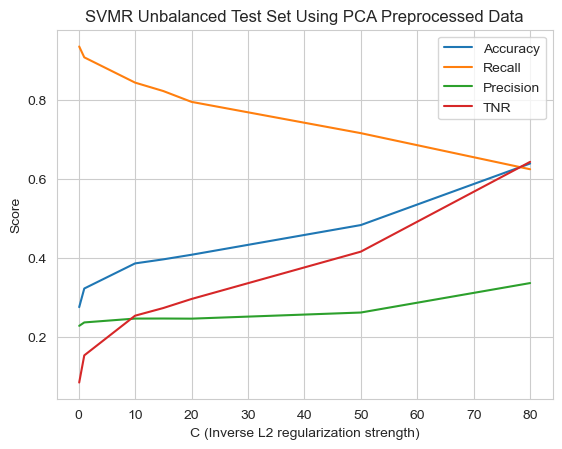

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')

plt.plot(C_vals, accuracies, label='Accuracy')
plt.plot(C_vals, recalls, label='Recall')
plt.plot(C_vals, precisions, label='Precision')
plt.plot(C_vals, TNRs, label='TNR')
plt.legend()
plt.xlabel('C (Inverse L2 regularization strength)')
plt.ylabel('Score')
plt.title('SVMR Unbalanced Test Set Using PCA Preprocessed Data')
# plt.savefig('images/svmr_unbalanced_pca_preprocessed_data.png')

plt.show()

In [131]:
y_pred_train = clf.predict(X_train_pca)

In [132]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_train

0.37068340980439507

In [122]:
np.unique(y_pred_train, return_counts=True)

(array([0., 1.]), array([1687, 6595]))

SVMR Using .99 PCA of Preprocessed Signal: .645

SVMR Using Normalized Original Signals: .602

SVMR Using Normalized Original Signals with PCA: .607

SVMR Using Preprocessed Signal: .591

SVMR Using Preprocessed Signal on Unbalanced Data: .694 Recall: .329

SVMR Using Normalized Original Signals on Unbalanced Data: .728 Recall: .357

SVMR Using Normalized Original Signals with PCA on Unbalanced Data: .722 Recall: .357

SVMR Using .99 PCA of Preprocessed Signal on Unbalanced Data: .67 Recall: .363


In [24]:
class_counts = np.bincount(y_train.astype(int))
class_priors = class_counts / len(y_train)

In [ ]:
# Initialize LDA model
lda = LinearDiscriminantAnalysis(priors=class_priors, shrinkage='auto', solver='lsqr')

# Train LDA model
lda.fit(X_train_no_preprocess, y_train)

# Predict on test data
y_pred = lda.predict(X_val_unbalanced_no_preprocess)

# Evaluate accuracy
accuracy = accuracy_score(y_val_unbalanced, y_pred)
recall = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1)
precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
TNR = np.sum(y_pred[y_val_unbalanced == 0] == 0) / np.sum(y_val_unbalanced == 0)

print(f"Accuracy: {accuracy:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}, TNR: {TNR:.2f}")

Accuracy: 0.78, Recall: 0.00, Precision: 0.00, TNR: 1.00


In [37]:
accuracies = []
recalls = []
precisions = []
TNRs = []

for solv in ['svd', 'lsqr', 'eigen']:
    lda = LinearDiscriminantAnalysis(priors=class_priors, shrinkage=None if solv == 'svd' else 'auto', solver=solv)
    lda.fit(X_train_pca, y_train)
    y_pred = lda.predict(X_val_unbalanced_pca)
    accuracy = accuracy_score(y_val_unbalanced, y_pred)
    recall = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_val_unbalanced == 1)
    precision = np.sum(y_pred[y_val_unbalanced == 1] == 1) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
    TNR = np.sum(y_pred[y_val_unbalanced == 0] == 0) / np.sum(y_val_unbalanced == 0)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    TNRs.append(TNR)
    

In [29]:
accuracies = []
recalls = []
precisions = []
TNRs = []
shrinkages = ['auto'] + list(np.arange(0.1, 1.1, 0.1))

for shrinkage in shrinkages:
    lda = LinearDiscriminantAnalysis(priors=class_priors, shrinkage=shrinkage, solver='eigen')
    lda.fit(X_train_pca, y_train)
    y_pred = lda.predict(X_val_pca)
    accuracy = accuracy_score(y_val, y_pred)
    recall = np.sum(y_pred[y_val == 1] == 1) / np.sum(y_val == 1)
    precision = np.sum(y_pred[y_val == 1] == 1) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
    TNR = np.sum(y_pred[y_val == 0] == 0) / np.sum(y_val == 0)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    TNRs.append(TNR)

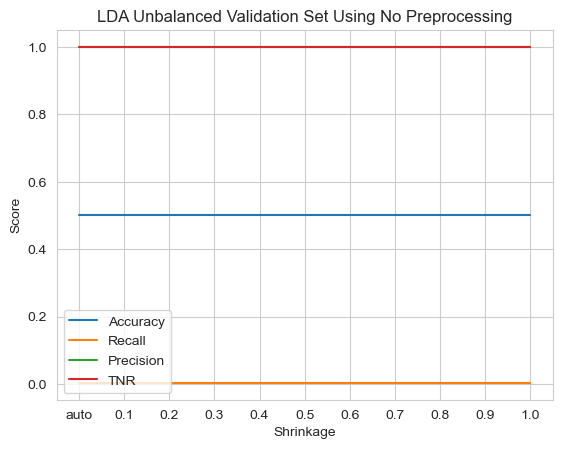

In [30]:
plt.plot(shrinkages, accuracies, label='Accuracy')
plt.plot(shrinkages, recalls, label='Recall')
plt.plot(shrinkages, precisions, label='Precision')
plt.plot(shrinkages, TNRs, label='TNR')
plt.xticks(range(11), [f"{s:.1f}" if isinstance(s, float) else s for s in shrinkages])

plt.legend()
plt.xlabel('Shrinkage')
plt.ylabel('Score')
plt.title('LDA Unbalanced Validation Set Using No Preprocessing')
plt.show()


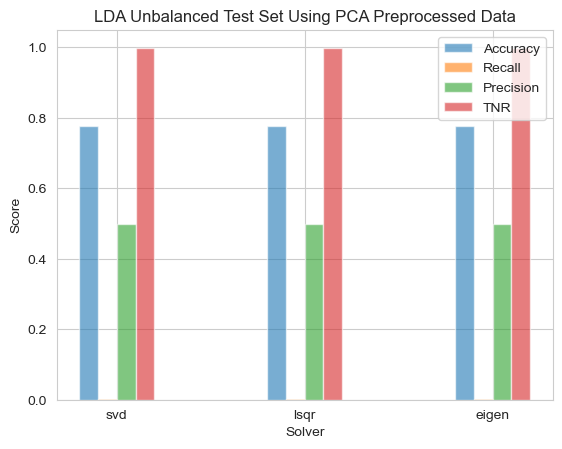

In [ ]:
sns.set_style('whitegrid')
num_bars = 4
bar_width = 0.15
labels = ['svd', 'lsqr', 'eigen']
# X positions for each label, with bars centered around them
x = np.arange(len(labels))
offsets = np.linspace(-bar_width, bar_width, num_bars)


plt.bar(x + offsets[0], accuracies, label='Accuracy', width=0.1, alpha=0.6)
plt.bar(x + offsets[1], recalls, label='Recall', width=0.1, alpha=0.6)
plt.bar(x + offsets[2], precisions, label='Precision', width=0.1, alpha=0.6)
plt.bar(x + offsets[3], TNRs, label='TNR', width=0.1, alpha=0.6)
plt.xticks(x, labels)

plt.legend()
plt.xlabel('Solver')
plt.ylabel('Score')
plt.title('LDA Unbalanced Test Set Using PCA Preprocessed Data')
# plt.savefig('../images/lda_unbalanced_pca_preprocessed_data_solver_comparison.png')

plt.show()

For unbalanced dataset validation best C is 20+ and for balanced dataset best C is 15-18

### DMNN

In [20]:
def max_s_x(centers, rs, x):
    s_c = x[:, np.newaxis, :] - centers
    norm_s_c = np.linalg.norm(s_c, axis=2)
    r_norm = rs - norm_s_c
    return r_norm.max(axis=1)

def get_centroids_radii(kmeans, X):
    centroids = kmeans.cluster_centers_
    radii = []
    for i in range(len(centroids)):
        cluster_points = X[kmeans.labels_ == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        radii.append(distances.max())
    
    return centroids, np.array(radii)

def error_calculation(excluded_X, inc_X, kmeans):
    centroids, radii = get_centroids_radii(kmeans, inc_X)
    max_s_all_X = max_s_x(centroids, radii, excluded_X)
    return np.sum(max_s_all_X > 0) / len(max_s_all_X)


In [21]:
rand_sample_ind = np.random.choice(np.where(y_train == 0)[0], len(X_train_pca[y_train == 1]), replace=False)
X_train_balanced = np.concatenate((X_train_pca[rand_sample_ind], X_train_pca[y_train == 1]))
y_train_balanced = np.concatenate((y_train[rand_sample_ind], y_train[y_train == 1]))
X_train = X_train_pca
y_train = labels
X_val = X_val_pca
y_val = labels_val

In [22]:
X_train_balanced.shape, y_train_balanced.shape

((3590, 33), (3590,))

In [23]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [24]:
import torch
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [26]:
from tqdm import tqdm
ce_loss = nn.CrossEntropyLoss(reduction='mean', weight=torch.tensor(class_weights, dtype=torch.float32))
focal_loss = FocalLoss()

class Spherical_Denrite(nn.Module):
    def __init__(self, c, r):
        super(Spherical_Denrite, self).__init__()
        self.centroid = nn.Parameter(torch.tensor(c, dtype=torch.float32), requires_grad=True)
        self.radii    = nn.Parameter(torch.tensor(r, dtype=torch.float32), requires_grad=False)

    def forward(self, x):
        # print(x.shape)
        # print(self.centroid.shape)
        distance = torch.sqrt(torch.clamp(torch.pow(x - self.centroid, 2).sum(1), min=1e-10))
        x = self.radii - distance # n x 1 where n is the number of samples
        return x
    
class SmoothMaximum(nn.Module):
    def __init__(self,beta=1.0):
        super(SmoothMaximum, self).__init__()
        self.beta = beta
        self.softmax = nn.Softmax(dim = 1) 
    def forward(self, dendrite_activations):
        # Dendrite activations is n x m_k where n is the number of samples and m_k is the number of dendrites in cluster k
        softmax = self.softmax(self.beta * dendrite_activations)
        return torch.sum(softmax * dendrite_activations, dim=1) # n x 1 where n is the number of samples
    

class DMNN(nn.Module):
    def __init__(self, data, labels, error_thresold, classes=2):
        super(DMNN, self).__init__()
        self.classes = classes
        self.spherical_dendrites = nn.ModuleList()
        self.output_nodes = nn.Linear(classes, classes)
  
        print("Initializing Spherical Dendrites using KMeans...")
        self.initialize_spherical_dendrites(data, labels, error_thresold)
        self.smoothmax = SmoothMaximum()

    def forward(self, inp):
        inp = inp.reshape(inp.shape[0], -1)
        dendrite_cluster = []
        for class_dendrites in self.spherical_dendrites:
            cluster_activations = [dendrite(inp) for _, dendrite in enumerate(class_dendrites)]
            
            cluster_activations = torch.stack(cluster_activations, dim=1)
            
            out = self.smoothmax(cluster_activations)

            dendrite_cluster.append(out)

        dendrite_cluster = torch.stack(dendrite_cluster, dim=1)
        out = self.output_nodes(dendrite_cluster)
        return out
    
    def initialize_spherical_dendrites(self, X_train, y_train, error_thresold):
        for class_ind in range(self.classes):
            in_class = X_train[y_train == class_ind]
            out_class = X_train[y_train != class_ind]
            num_clusters = int(in_class.shape[0] * .6)
            below_error = False
            cluster_pbar = tqdm(desc=f"Finding Optimal Clusters with Error Thresold {error_thresold}")
            cluster_pbar.reset()
            while not below_error:
                kmeans = KMeans(n_clusters=num_clusters)
                kmeans.fit(in_class)
                error = error_calculation(out_class, in_class, kmeans)
                if error < error_thresold[class_ind]:
                    below_error = True
                else:
                    num_clusters += 25
                cluster_pbar.update(1)
            cluster_pbar.close()
            
            print(f"Optimal Clusters Found: {num_clusters}")
            centroids, radii = get_centroids_radii(kmeans, in_class)
            class_spherical_dendrites = nn.ModuleList()
            for i in range(len(centroids)):
                if radii[i] == 0:
                    continue
                class_spherical_dendrites.append(Spherical_Denrite(centroids[i], radii[i]))
            
            self.spherical_dendrites.append(class_spherical_dendrites)
    
    def dmnn_loss(self, y_pred, y):
        return ce_loss(y_pred, y)



In [27]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [28]:
def validate_model(model, x, y):
  with torch.no_grad():
    # Get the Hidden States
    model_out = model(torch.tensor(x, dtype=torch.float32))

    x_preds = torch.argmax(model_out, dim=1).numpy()
    accuracy = accuracy_score(y, x_preds)
    if np.sum(x_preds == 1) == 0:
        precision = 0
    else:
        precision = np.sum(x_preds[y == 1] == 1) / np.sum(x_preds == 1)
    recall = np.sum(x_preds[y == 1] == 1) / np.sum(y == 1)
    TNR = np.sum(x_preds[y == 0] == 0) / np.sum(y == 0)

    return accuracy, precision, recall, TNR

def model_training_and_validating(data_split, error_threshold=[.4, .4], num_epochs=400, silent=False, concat_train_test=False):
    X_train, y_train, X_val, y_val = data_split
    
    dmnn_model = DMNN(X_train, y_train, error_thresold=error_threshold, classes=2)

    optimizer = optim.Adam(dmnn_model.parameters(), lr=1e-3)
    dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=96, shuffle=True)
    loss_keys = ['ce_loss']
    x_train_metrics = ['x_train_accuracy', 'x_train_precision', 'x_train_recall', 'x_train_TNR']
    x_test_metrics = ['x_test_accuracy', 'x_test_precision', 'x_test_recall', 'x_test_TNR']
    losses_dict = {k: [] for k in loss_keys}
    metrics_dict = {k: [] for k in x_train_metrics + x_test_metrics}

    print("Training Model...")
    for epoch in range(1, num_epochs + 1):
        dmnn_model.train()  
        total_ce_loss = 0
        for _, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            model_out = dmnn_model(x)
            ce_loss = dmnn_model.dmnn_loss(model_out, y)
            total_ce_loss += ce_loss.item()
            ce_loss.backward()
            optimizer.step()

        losses_dict['ce_loss'].append(total_ce_loss)

        x_train_accuracy, x_train_precision, x_train_recall, x_train_TNR = validate_model(dmnn_model, X_train, y_train)
        x_test_accuracy, x_test_precision, x_test_recall, x_test_TNR = validate_model(dmnn_model, X_val, y_val)

        metrics_dict['x_train_accuracy'].append(x_train_accuracy); metrics_dict['x_train_precision'].append(x_train_precision); metrics_dict['x_train_recall'].append(x_train_recall); metrics_dict['x_train_TNR'].append(x_train_TNR)

        metrics_dict['x_test_accuracy'].append(x_test_accuracy); metrics_dict['x_test_precision'].append(x_test_precision); metrics_dict['x_test_recall'].append(x_test_recall); metrics_dict['x_test_TNR'].append(x_test_TNR)

        if (epoch % 5 == 0 or epoch == 1) and not silent:
            print(f"Epoch {epoch}:")
            print(f"CE_Loss: {total_ce_loss:.2f}")
            print(f"Test Accuracy: {x_test_accuracy:.2f}, Test Precision: {x_test_precision:.2f}, Test Recall: {x_test_recall:.2f}, Test TNR: {x_test_TNR:.2f}")
            print()


    return dmnn_model, losses_dict, metrics_dict

In [29]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8282, 33), (8282,), (656, 33), (656,))

In [30]:
model, losses_dict, metrics_dict = model_training_and_validating([X_train, y_train, X_val_unbalanced_pca, y_val_unbalanced], num_epochs=40, silent=False)  

Initializing Spherical Dendrites using KMeans...


Finding Optimal Clusters with Error Thresold [0.4, 0.4]: 0it [00:00, ?it/s]/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Finding Optimal Clusters with Error Thresold [0.4, 0.4]: 1it [00:05,  5.16s/it]


Optimal Clusters Found: 3892


Finding Optimal Clusters with Error Thresold [0.4, 0.4]: 1it [00:02,  2.79s/it]


Optimal Clusters Found: 1077
Training Model...
Epoch 1:
CE_Loss: 68409.97
Test Accuracy: 0.45, Test Precision: 0.24, Test Recall: 0.68, Test TNR: 0.38

Epoch 5:
CE_Loss: 1456.59
Test Accuracy: 0.57, Test Precision: 0.26, Test Recall: 0.50, Test TNR: 0.60

Epoch 10:
CE_Loss: 1218.49
Test Accuracy: 0.59, Test Precision: 0.27, Test Recall: 0.49, Test TNR: 0.62

Epoch 15:
CE_Loss: 1189.20
Test Accuracy: 0.60, Test Precision: 0.27, Test Recall: 0.49, Test TNR: 0.63

Epoch 20:
CE_Loss: 1124.33
Test Accuracy: 0.60, Test Precision: 0.27, Test Recall: 0.48, Test TNR: 0.63

Epoch 25:
CE_Loss: 1034.45
Test Accuracy: 0.60, Test Precision: 0.28, Test Recall: 0.47, Test TNR: 0.64

Epoch 30:
CE_Loss: 967.87
Test Accuracy: 0.61, Test Precision: 0.27, Test Recall: 0.45, Test TNR: 0.65

Epoch 35:
CE_Loss: 902.95
Test Accuracy: 0.61, Test Precision: 0.27, Test Recall: 0.45, Test TNR: 0.66

Epoch 40:
CE_Loss: 840.49
Test Accuracy: 0.61, Test Precision: 0.28, Test Recall: 0.45, Test TNR: 0.66



In [41]:
with torch.no_grad():
    model_out = model(torch.tensor(X_val_unbalanced_pca, dtype=torch.float32))

    x_preds = torch.argmax(model_out, dim=1).numpy()
    

In [42]:
x_preds.shape


(1462,)

In [55]:
# Select two dimensions for visualization
dim1, dim2 = 0, 1  # Indices of features to visualize

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_val)

pca_75 = PCA(n_components=33)
pca_75.fit(X_val)

# Create a grid for the selected dimensions
x_min, x_max = X_2d[:, dim1].min() - 1, X_2d[:, dim1].max() + 1
y_min, y_max = X_2d[:, dim2].min() - 1, X_2d[:, dim2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Create a grid in the original 75D space
grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
grid_points_full = pca.inverse_transform(grid_points_2d)
grid_points_75d = pca_75.transform(grid_points_full)

# Get predictions for the grid points
with torch.no_grad():
    Z = model(torch.tensor(grid_points_75d, dtype=torch.float32)).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

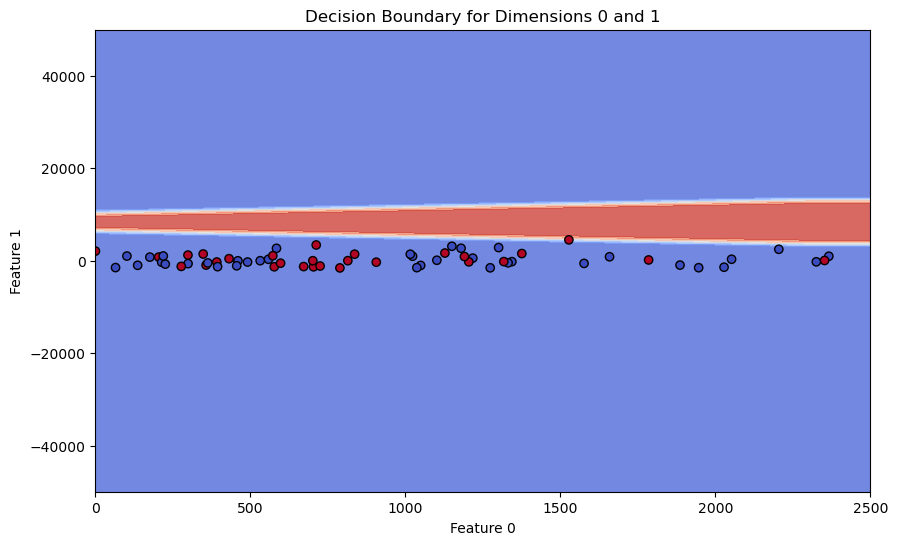

In [61]:
# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_2d[:, dim1], X_2d[:, dim2], c=y_val, edgecolor='k', cmap=plt.cm.coolwarm)
plt.title(f"Decision Boundary for Dimensions {dim1} and {dim2}")
plt.xlabel(f"Feature {dim1}")
plt.ylabel(f"Feature {dim2}")
plt.xlim(0, 2500)
plt.ylim(-50000, 50000)
plt.show()

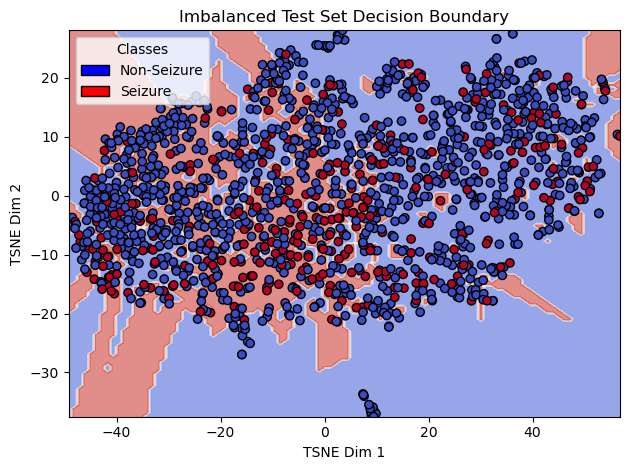

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from matplotlib.patches import Patch
# replace the below by your data and model
X_Train_embedded = TSNE(n_components=2).fit_transform(X_val_unbalanced_pca)
# replace the above by your data and model

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, x_preds) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground, cmap=plt.cm.coolwarm, alpha=0.6)
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_val_unbalanced, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Imbalanced Test Set Decision Boundary")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
legend_elements = [
    Patch(facecolor="blue", edgecolor="k", label="Non-Seizure"),
    Patch(facecolor="red", edgecolor="k", label="Seizure"),
]
plt.legend(handles=legend_elements, loc="upper left", title="Classes")
plt.tight_layout()
# plt.savefig('../images/imbalanced_test_set_decision_boundary.png')
plt.show()

In [10]:
print("""
===============================================================================================
Layer (type:depth-idx)                        Output Shape              Param #
===============================================================================================
DMNN                                          [1, 2]                    --
├─ModuleList: 1-3                             --                        (recursive)
│    └─ModuleList: 2-1                        --                        --
│    │    └─Spherical_Denrite: 3-1            [1]                       76
│    │    └─Spherical_Denrite: 3-2            [1]                       76
│    │    └─Spherical_Denrite: 3-3            [1]                       76
│    │    └─Spherical_Denrite: 3-4            [1]                       76
...
├─SmoothMaximum: 1-2                          [1]                       --
│    └─Softmax: 2-2                           [1, 3208]                 --
├─ModuleList: 1-3                             --                        (recursive)
│    └─ModuleList: 2-3                        --                        --
│    │    └─Spherical_Denrite: 3-3209         [1]                       76
│    │    └─Spherical_Denrite: 3-3210         [1]                       76
│    │    └─Spherical_Denrite: 3-3211         [1]                       76
...
│    │    └─Spherical_Denrite: 3-4251         [1]                       76
├─SmoothMaximum: 1-4                          [1]                       --
│    └─Softmax: 2-4                           [1, 1043]                 --
├─Linear: 1-5                                 [1, 2]                    6
===============================================================================================
Total params: 323,082
Trainable params: 318,831
Non-trainable params: 4,251
Total mult-adds (M): 0.00
===============================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.16
Estimated Total Size (MB): 1.19
===============================================================================================
""")


Layer (type:depth-idx)                        Output Shape              Param #
DMNN                                          [1, 2]                    --
├─ModuleList: 1-3                             --                        (recursive)
│    └─ModuleList: 2-1                        --                        --
│    │    └─Spherical_Denrite: 3-1            [1]                       76
│    │    └─Spherical_Denrite: 3-2            [1]                       76
│    │    └─Spherical_Denrite: 3-3            [1]                       76
│    │    └─Spherical_Denrite: 3-4            [1]                       76
...
├─SmoothMaximum: 1-2                          [1]                       --
│    └─Softmax: 2-2                           [1, 3208]                 --
├─ModuleList: 1-3                             --                        (recursive)
│    └─ModuleList: 2-3                        --                        --
│    │    └─Spherical_Denrite: 3-3209         [1]                       

In [34]:
from torchinfo import summary

summary(model, input_size=(1, X_train.shape[1]))

Layer (type:depth-idx)                        Output Shape              Param #
DMNN                                          [1, 2]                    --
├─ModuleList: 1-3                             --                        (recursive)
│    └─ModuleList: 2-1                        --                        --
│    │    └─Spherical_Denrite: 3-1            [1]                       34
│    │    └─Spherical_Denrite: 3-2            [1]                       34
│    │    └─Spherical_Denrite: 3-3            [1]                       34
│    │    └─Spherical_Denrite: 3-4            [1]                       34
│    │    └─Spherical_Denrite: 3-5            [1]                       34
│    │    └─Spherical_Denrite: 3-6            [1]                       34
│    │    └─Spherical_Denrite: 3-7            [1]                       34
│    │    └─Spherical_Denrite: 3-8            [1]                       34
│    │    └─Spherical_Denrite: 3-9            [1]                       34
│    │    └

In [29]:
accuracy, precision, recall, TNR = metrics_dict['x_test_accuracy'], metrics_dict['x_test_precision'], metrics_dict['x_test_recall'], metrics_dict['x_test_TNR']

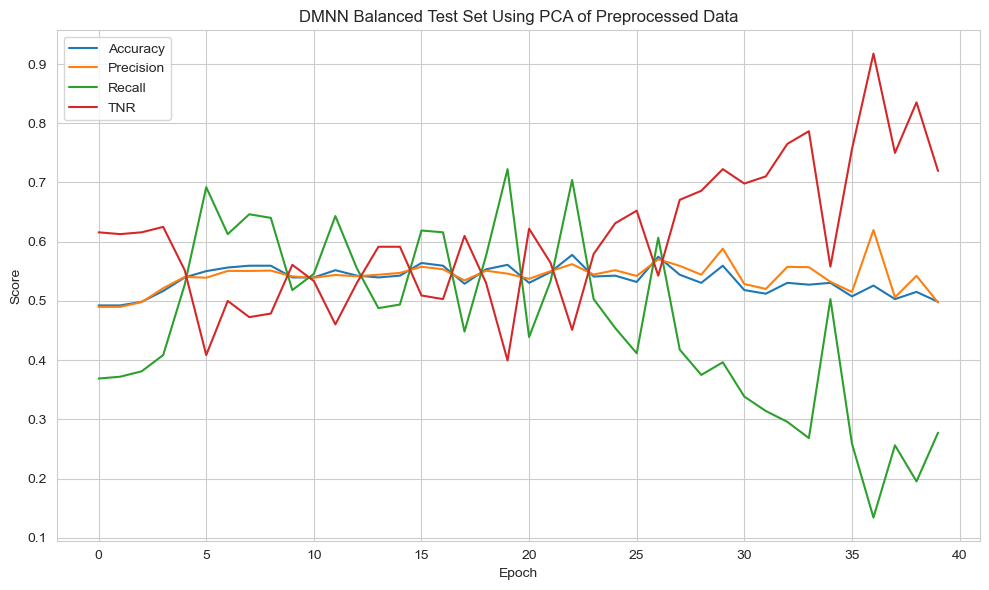

In [32]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10, 6))

plt.plot(accuracy, label='Accuracy')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(TNR, label='TNR')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('DMNN Balanced Test Set Using PCA of Preprocessed Data')
plt.tight_layout()
plt.savefig('../images/dmnn_balanced_pca_preprocessed_data.png')
plt.show()

In [71]:
sig_2 = [22, 20, 17, 15, 18, 20, 15, 17]
sig_1 = [23, 24, 25, 27, 26, 22, 20, 18]
dp = [[0 for _ in range(len(sig_1))] for _ in range(len(sig_1))]


for i in range(len(sig_1)):
    for j in range(len(sig_1)):
        dp[i][j] = abs(sig_1[i] - sig_2[j])
        prev_values = []
        if i > 0:
            prev_values.append(dp[i-1][j])
        if j > 0:
            prev_values.append(dp[i][j-1])
        if i > 0 and j > 0:
            prev_values.append(dp[i-1][j-1])
        if len(prev_values) > 0:
            dp[i][j] += min(prev_values)
            
dtw_matrix = list(reversed(dp))
queue = [(0, len(sig_1)-1)]
path = []
while queue:
    r, c = queue.pop(0)
    path.append(dtw_matrix[r][c])
    if r == len(sig_1)-1 and c == 0:
        break
    min_values = []

    if r < len(sig_1)-1:
        min_values.append(((r+1, c), 3))
    if c > 0:
        min_values.append(((r, c-1), 2))
    if r < len(sig_1)-1 and c > 0:
        min_values.append(((r+1, c-1), 1))
    
    (smallest_r, smallest_c), _ = min(min_values, key=lambda x: (dtw_matrix[x[0][0]][x[0][1]], x[1]))

    queue.append((smallest_r, smallest_c))
    
total_distance = 0
for i in range (len(path)-1, 1, -1):
    total_distance += (path[i] - path[i-1])**2

In [72]:
dtw_matrix

[[21, 17, 16, 19, 19, 21, 24, 25],
 [17, 15, 18, 23, 25, 25, 30, 33],
 [15, 17, 22, 29, 33, 35, 42, 47],
 [15, 17, 22, 29, 33, 36, 44, 50],
 [11, 13, 18, 25, 30, 33, 41, 47],
 [6, 8, 13, 21, 26, 29, 37, 43],
 [3, 5, 11, 19, 24, 27, 35, 41],
 [1, 4, 10, 18, 23, 26, 34, 40]]

In [73]:
path

[25, 24, 21, 19, 19, 16, 15, 15, 15, 11, 6, 3, 1]

In [40]:
total_distance = 0
for i in range (len(path)-1, 0, -1):
    total_distance += (path[i] - path[i-1])**2

In [41]:
total_distance

45

In [42]:
dp = [[0 for _ in range(11)] for _ in range(11)]
sig_1 = [5, 8, 10, 4, 7, 1, 8, 7, 1, 6, 4]
sig_2 = [6, 5, 6, 5, 7, 10, 3, 5, 3, 6, 6]

for i in range(11):
    for j in range(11):
        dp[i][j] = abs(sig_1[i] - sig_2[j])
        prev_values = []
        if i > 0:
            prev_values.append(dp[i-1][j])
        if j > 0:
            prev_values.append(dp[i][j-1])
        if i > 0 and j > 0:
            prev_values.append(dp[i-1][j-1])
        if len(prev_values) > 0:
            dp[i][j] += min(prev_values)
            
dtw_matrix = list(reversed(dp))
queue = [(0, 10)]
path = []
while queue:
    r, c = queue.pop(0)
    path.append(dtw_matrix[r][c])
    if r == 10 and c == 0:
        break
    min_values = []

    if r+1 < 11 and 12 > r+1 + c > 8:
        min_values.append(((r+1, c), 3))
    if c-1 >= 0 and 12 > r + c-1 > 8:
        min_values.append(((r, c-1), 2))
    if r+1 < 11 and c-1 >= 0:
        min_values.append(((r+1, c-1), 1))
    
    print(r,c)
    (smallest_r, smallest_c), _ = min(min_values, key=lambda x: (dtw_matrix[x[0][0]][x[0][1]], x[1]))

    queue.append((smallest_r, smallest_c))
    
total_distance = 0
for i in range (len(path)-1, 1, -1):
    total_distance += (path[i] - path[i-1])**2

0 10
1 9
2 9
3 8
4 7
5 6
6 5
6 4
7 3
8 2
9 2
10 1


In [43]:
path

[18, 16, 16, 17, 13, 10, 11, 8, 8, 7, 3, 1, 1]

In [64]:
def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)**2 / (2 * sigma**2)))

params = {
    0: (0, 1.8),
    1: (-1, 1.6), 
    2: (1, 1.3), 
}

transition_matrix = [
    [0.5, 0.3, 0.1, 0.1], 
    [0, 0.5, 0.2, 0.3],
    [0, 0.1, 0.5, 0.4],
]

prior = [0.7, 0.3, 0]
emissions = [0.3, -0.1, 0.3, 0.5]

def find_most_likely_sequence(i, emissions, state_chain, prob):
    if i == len(emissions):
        prob *= transition_matrix[state_chain[-1]][3]
        return prob, list(state_chain)
    
    max_prob = 0
    max_state = 0
    for j in range(3):
        transition_prob = transition_matrix[state_chain[-1]][j] if state_chain else prior[j]
        iter_prob = prob * normal_pdf(emissions[i], *params[j]) * transition_prob
        state_chain.append(j)
        new_prob, new_state_chain = find_most_likely_sequence(i+1, emissions, state_chain, iter_prob)
        if new_prob > max_prob:
            max_prob = new_prob
            max_state = new_state_chain
        state_chain.pop()
    
    return max_prob, max_state


In [83]:
dp = [[0 for _ in range(5)] for _ in range(2)]
trellis_path = [[[] for _ in range(5)] for _ in range(2)]
transition_matrix = [
    [0.6, 0.4],
    [0.3, 0.7],
]

emission_probs = [
    [0.85, 0.15],
    [0.15, 0.85],
]
emissions = [1, 1, 0, 0, 1]

for i in range(5):
    for j in range(2):
        max_prob = 0
        max_transition_prob = 0
        max_prev_prob = 0 
        max_emission_prob = 0
        max_prev_state = None
        for k in range(2):
            prev_prob = dp[k][i-1] if i > 0 else 0.5
            transition_prob = transition_matrix[k][j] if i > 0 else 1
            emission_prob = emission_probs[emissions[i]][j]
            prob = prev_prob * transition_prob * emission_prob
            if prob > max_prob:
                max_prob = prob
                max_transition_prob = transition_prob
                max_prev_prob = prev_prob
                max_emission_prob = emission_prob
                max_prev_state = k

        trellis_path[j][i] = list(trellis_path[max_prev_state][i-1]) + [j] if i > 0 else [j]
        print(f"Max prob: {max_prob}, transition prob: {max_transition_prob}, prev prob: {max_prev_prob}, emission prob: {max_emission_prob}")
        dp[j][i] = max_prob

Max prob: 0.075, transition prob: 1, prev prob: 0.5, emission prob: 0.15
Max prob: 0.425, transition prob: 1, prev prob: 0.5, emission prob: 0.85
Max prob: 0.019125, transition prob: 0.3, prev prob: 0.425, emission prob: 0.15
Max prob: 0.25287499999999996, transition prob: 0.7, prev prob: 0.425, emission prob: 0.85
Max prob: 0.06448312499999999, transition prob: 0.3, prev prob: 0.25287499999999996, emission prob: 0.85
Max prob: 0.026551874999999992, transition prob: 0.7, prev prob: 0.25287499999999996, emission prob: 0.15
Max prob: 0.03288639374999999, transition prob: 0.6, prev prob: 0.06448312499999999, emission prob: 0.85
Max prob: 0.0038689874999999993, transition prob: 0.4, prev prob: 0.06448312499999999, emission prob: 0.15
Max prob: 0.0029597754374999993, transition prob: 0.6, prev prob: 0.03288639374999999, emission prob: 0.15
Max prob: 0.011181373874999997, transition prob: 0.4, prev prob: 0.03288639374999999, emission prob: 0.85


In [84]:
trellis_path

[[[0], [1, 0], [1, 1, 0], [1, 1, 0, 0], [1, 1, 0, 0, 0]],
 [[1], [1, 1], [1, 1, 1], [1, 1, 0, 1], [1, 1, 0, 0, 1]]]

In [65]:
highest_prob, state_chain = find_most_likely_sequence(0, emissions, [], 1)

In [66]:
state_chain, highest_prob

([0, 1, 2, 2], 2.9567834666233092e-05)

In [57]:
state_values = {
    3: 100,
    5: 100, 
    6: 100, 
    8: 100, 
    10: 100, 
    12: 60, 
    20: 60, 
    22: 60, 
    24: 60, 
    48: 20,
}

def action_prob_next_state(action, curr_state):
    if action == "BUY":
        if curr_state <= 10:
            return 0.5 * 0.9 * state_values[int(curr_state * 0.5)] + 0.25 * 0.9 * state_values[curr_state] + 0.25 * 0.9 * state_values[int(curr_state * 2)] - .5 * curr_state
        
        return 0.5 * 0.9 * state_values[int(curr_state * 2)] + 0.25 * 0.9 * state_values[curr_state] + 0.25 * 0.9 * state_values[int(curr_state * 0.5)] - .5 * curr_state
    elif action == "HOLD":
        if curr_state <= 10:
            return 0.5 * 0.9 * state_values[curr_state + 2] + 0.5 * 0.9 * state_values[curr_state] + 1 
        return 0.5 * 0.9 * state_values[curr_state - 2] + 0.5 * 0.9 * state_values[curr_state] + 1
    else:
        if curr_state <= 10:
            return 0.5 * 0.9 * state_values[int(curr_state * 2)] + 0.25 * 0.9 * state_values[curr_state] + 0.25 * 0.9 * state_values[int(curr_state * 0.5)] + .5 * curr_state
        return 0.5 * 0.9 * state_values[int(curr_state * 0.5)] + 0.25 * 0.9 * state_values[curr_state] + 0.25 * 0.9 * state_values[int(curr_state * 2)] + .5 * curr_state


In [58]:
new_state_values = {}

for state in [6, 12, 24]:
    new_state_values[state] = action_prob_next_state("BUY", state)

In [71]:
state_values = new_state_values

action_prob_next_state("SELL", 12)

59.325

In [5]:
def calculate_fitness_value(matrix):
    fitness_value = 0 
    for row in matrix:
        fitness_value += abs(15 - sum(row))
    print(f"Row: {fitness_value}")
    for col in range(len(matrix[0])):
        fitness_value += abs(15 - sum([row[col] for row in matrix]))
    print(f"Col: {fitness_value}")
    # Diagonal 1
    fitness_value += abs(15 - sum([matrix[i][i] for i in range(len(matrix))]))
    print(f"Diag 1: {fitness_value}")

    # Diagonal 2
    fitness_value += abs(15 - sum([matrix[i][len(matrix) - i - 1] for i in range(len(matrix))]))
    print(f"Diag 2: {fitness_value}")

    return fitness_value

In [ ]:
mat = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
]

best_fitness = calculate_fitness_value(mat)
best_swap = None
for i in range(len(mat)):
    for j in range(len(mat[0])):
        for k in range(len(mat)):
            for l in range(len(mat[0])):
                if i == k and j == l:
                    continue
                mat[i][j], mat[k][l] = mat[k][l], mat[i][j]
                curr_fitness = calculate_fitness_value(mat)
                if curr_fitness < best_fitness:
                    best_fitness = curr_fitness
                    best_swap = (i, j, k, l)
                    
                mat[i][j], mat[k][l] = mat[k][l], mat[i][j]
                print()

Row: 18
Col: 24
Diag 1: 24
Diag 2: 24
Swapping 0 0 with 0 1
Row: 18
Col: 24
Diag 1: 25
Diag 2: 25
Fitness: 25

Swapping 0 0 with 0 2
Row: 18
Col: 20
Diag 1: 22
Diag 2: 24
Fitness: 24

Swapping 0 0 with 1 0
Row: 18
Col: 24
Diag 1: 27
Diag 2: 27
Fitness: 27

Swapping 0 0 with 1 1
Row: 18
Col: 26
Diag 1: 26
Diag 2: 30
Fitness: 30

Swapping 0 0 with 1 2
Row: 18
Col: 22
Diag 1: 27
Diag 2: 27
Fitness: 27

Swapping 0 0 with 2 0
Row: 6
Col: 12
Diag 1: 18
Diag 2: 24
Fitness: 24

Swapping 0 0 with 2 1
Row: 4
Col: 18
Diag 1: 25
Diag 2: 25
Fitness: 25

Swapping 0 0 with 2 2
Row: 2
Col: 12
Diag 1: 12
Diag 2: 12
Fitness: 12

Swapping 0 1 with 0 0
Row: 18
Col: 24
Diag 1: 25
Diag 2: 25
Fitness: 25

Swapping 0 1 with 0 2
Row: 18
Col: 24
Diag 1: 24
Diag 2: 25
Fitness: 25

Swapping 0 1 with 1 0
Row: 18
Col: 28
Diag 1: 28
Diag 2: 28
Fitness: 28

Swapping 0 1 with 1 1
Row: 18
Col: 24
Diag 1: 27
Diag 2: 30
Fitness: 30

Swapping 0 1 with 1 2
Row: 18
Col: 26
Diag 1: 26
Diag 2: 26
Fitness: 26

Swapping 0 1 wit

In [11]:
mat = [
    [9,2,3],
    [4,5,6],
    [7,8,1],
]
calculate_fitness_value(mat)

Row: 2
Col: 12
Diag 1: 12
Diag 2: 12


12

In [10]:
best_fitness, best_swap

(12, (0, 0, 2, 2))

In [12]:
mat = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
]

best_fitness = calculate_fitness_value(mat)
best_swap = None
for i in range(len(mat)):
    for j in range(len(mat[0])):
        for k in range(len(mat)):
            for l in range(len(mat[0])):
                if i == k and j == l:
                    continue
                mat[i][j], mat[k][l] = mat[k][l], mat[i][j]
                curr_fitness = calculate_fitness_value(mat)
                if curr_fitness > best_fitness:
                    best_fitness = curr_fitness
                    best_swap = (i, j, k, l)
                    
                mat[i][j], mat[k][l] = mat[k][l], mat[i][j]
                print()

Row: 18
Col: 24
Diag 1: 24
Diag 2: 24
Row: 18
Col: 24
Diag 1: 25
Diag 2: 25

Row: 18
Col: 20
Diag 1: 22
Diag 2: 24

Row: 18
Col: 24
Diag 1: 27
Diag 2: 27

Row: 18
Col: 26
Diag 1: 26
Diag 2: 30

Row: 18
Col: 22
Diag 1: 27
Diag 2: 27

Row: 6
Col: 12
Diag 1: 18
Diag 2: 24

Row: 4
Col: 18
Diag 1: 25
Diag 2: 25

Row: 2
Col: 12
Diag 1: 12
Diag 2: 12

Row: 18
Col: 24
Diag 1: 25
Diag 2: 25

Row: 18
Col: 24
Diag 1: 24
Diag 2: 25

Row: 18
Col: 28
Diag 1: 28
Diag 2: 28

Row: 18
Col: 24
Diag 1: 27
Diag 2: 30

Row: 18
Col: 26
Diag 1: 26
Diag 2: 26

Row: 8
Col: 24
Diag 1: 24
Diag 2: 29

Row: 6
Col: 12
Diag 1: 12
Diag 2: 12

Row: 4
Col: 18
Diag 1: 25
Diag 2: 25

Row: 18
Col: 20
Diag 1: 22
Diag 2: 24

Row: 18
Col: 24
Diag 1: 24
Diag 2: 25

Row: 18
Col: 26
Diag 1: 26
Diag 2: 27

Row: 18
Col: 28
Diag 1: 30
Diag 2: 30

Row: 18
Col: 24
Diag 1: 24
Diag 2: 27

Row: 10
Col: 24
Diag 1: 24
Diag 2: 24

Row: 8
Col: 24
Diag 1: 24
Diag 2: 29

Row: 6
Col: 12
Diag 1: 18
Diag 2: 24

Row: 18
Col: 24
Diag 1: 27
Diag 2:

In [18]:
import numpy as np
from scipy.stats import multivariate_normal

# Example parameters
mean = np.array([18, 45])  # Mean vector
covariance = np.array([[8., 0.], [0., 8.]])  # Covariance matrix
point = np.array([15, 40])  # Point vector

# Calculate the PDF using scipy.stats.multivariate_normal
pdf = multivariate_normal.pdf(point, mean=mean, cov=covariance)

print(f"The likelihood (PDF) at the point {point} is {pdf}")

The likelihood (PDF) at the point [15 40] is 0.0023760434084732374


In [17]:
component_one_pdf = pdf

In [19]:
component_two_pdf = pdf

In [20]:
component_one_pdf, component_two_pdf

(1.1862305470508222e-07, 0.0023760434084732374)

In [21]:
0.5 * component_one_pdf / (0.5 * component_one_pdf + 0.5 * component_two_pdf)

4.9922123630939464e-05

In [22]:
.000049922123630939464

4.9922123630939464e-05

In [23]:
0.5 * component_two_pdf / (0.5 * component_one_pdf + 0.5 * component_two_pdf)

0.9999500778763691

In [114]:
import math 
35 * math.log(10000) -2 * -9400

19122.361913019166

In [43]:
import numpy as np
from collections import Counter

def calculate_entropy(feature_values):
    # Count the frequencies of each category
    counts = Counter(feature_values)
    total = len(feature_values)

    # Calculate probabilities
    probabilities = np.array([count / total for count in counts.values()])

    # Compute entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Example usage
feature = ['C', 'T', 'A', 'C', 'T', 'A', 'C', 'T']
entropy = calculate_entropy(feature)
print(f"Entropy: {entropy} bits")

Entropy: 1.561278124459133 bits


In [44]:
entropy_total = calculate_entropy(['C', 'T', 'A', 'C', 'T', 'A', 'C', 'T'])

In [45]:
entropy_total

1.561278124459133

In [40]:
entropy_right = entropy
entropy_left = 1

In [47]:
info_gain_hsv = entropy_total - (1/2 * entropy_right + 1/2 * entropy_left)

In [48]:
info_gain_hsv

0.6556390622295665

In [51]:
entropy_left_water = calculate_entropy(['C', 'A', 'A'])

In [55]:
entropy_right_water = calculate_entropy(['T', 'C', 'T', 'C', 'T'])

In [56]:
info_gain_water = entropy_total - (3/8 * entropy_left_water + 5/8 * entropy_right_water)

In [57]:
info_gain_water

0.6100730651545314

In [116]:
3/8


0.375

In [118]:
-.75*(np.log2(3/8) + np.log2(3/8)) - (1/4)*np.log2(1/4)

2.622556248918266

In [115]:
-((3/8)*np.log2(3/8) + (3/8)*np.log2(3/8) + (1/4)*np.log2(1/4))

1.561278124459133

In [90]:
def implies(a, b):
    return not a or b
def biconditional(a, b):
    return implies(a, b) and implies(b, a)

In [93]:
def logical_circuit(cs, aw, lq, hm):
    l1 = cs or aw
    l2 = not (aw and not lq)
    l3 = cs and implies(hm, lq)
    l4 = aw and biconditional(lq, not cs)

    l5 = implies(l1, l2)
    l6 = implies(l2 or l3, implies(l4, l3))
    print(f"l1: {l1}, l2: {l2}, l3: {l3}, l4: {l4}, l5: {l5}, l6: {l6}")
    return implies(l5, not l6)

In [109]:
logical_circuit(0, 0, 1, 1)

l1: 0, l2: True, l3: 0, l4: 0, l5: True, l6: True


False

In [110]:
64*64*425+425+ 425*255 + 255 + 255*80+ 80 + 80*6 + 6

1870821

In [113]:
25*32+32 + 3 * 3 * 32 * 16 + 16 + 30*30*16*50 + 50 + 50 * 6 + 6

725812

In [112]:
50 * 6 + 6

306